In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
data_dir  ='/home/yiyi/Documents/masterthesis/CPD/data/rolling_window/'
result_dir = os.path.join(data_dir, 'results')

In [3]:
filename ='38#10e5a62b-4347-4bf3-a4a8-609de83f2dfe'

In [4]:
df = pd.read_csv(os.path.join(data_dir, 'renovation', filename))

In [5]:
from utils import *
from window_rolling import *

In [6]:
cpd_df = get_cpd_df(df)

In [7]:
cpd_df.head(2)

,date,score
0,2002-11-29,1.0
1,2004-03-09,1.0


In [8]:
%matplotlib inline

54 161


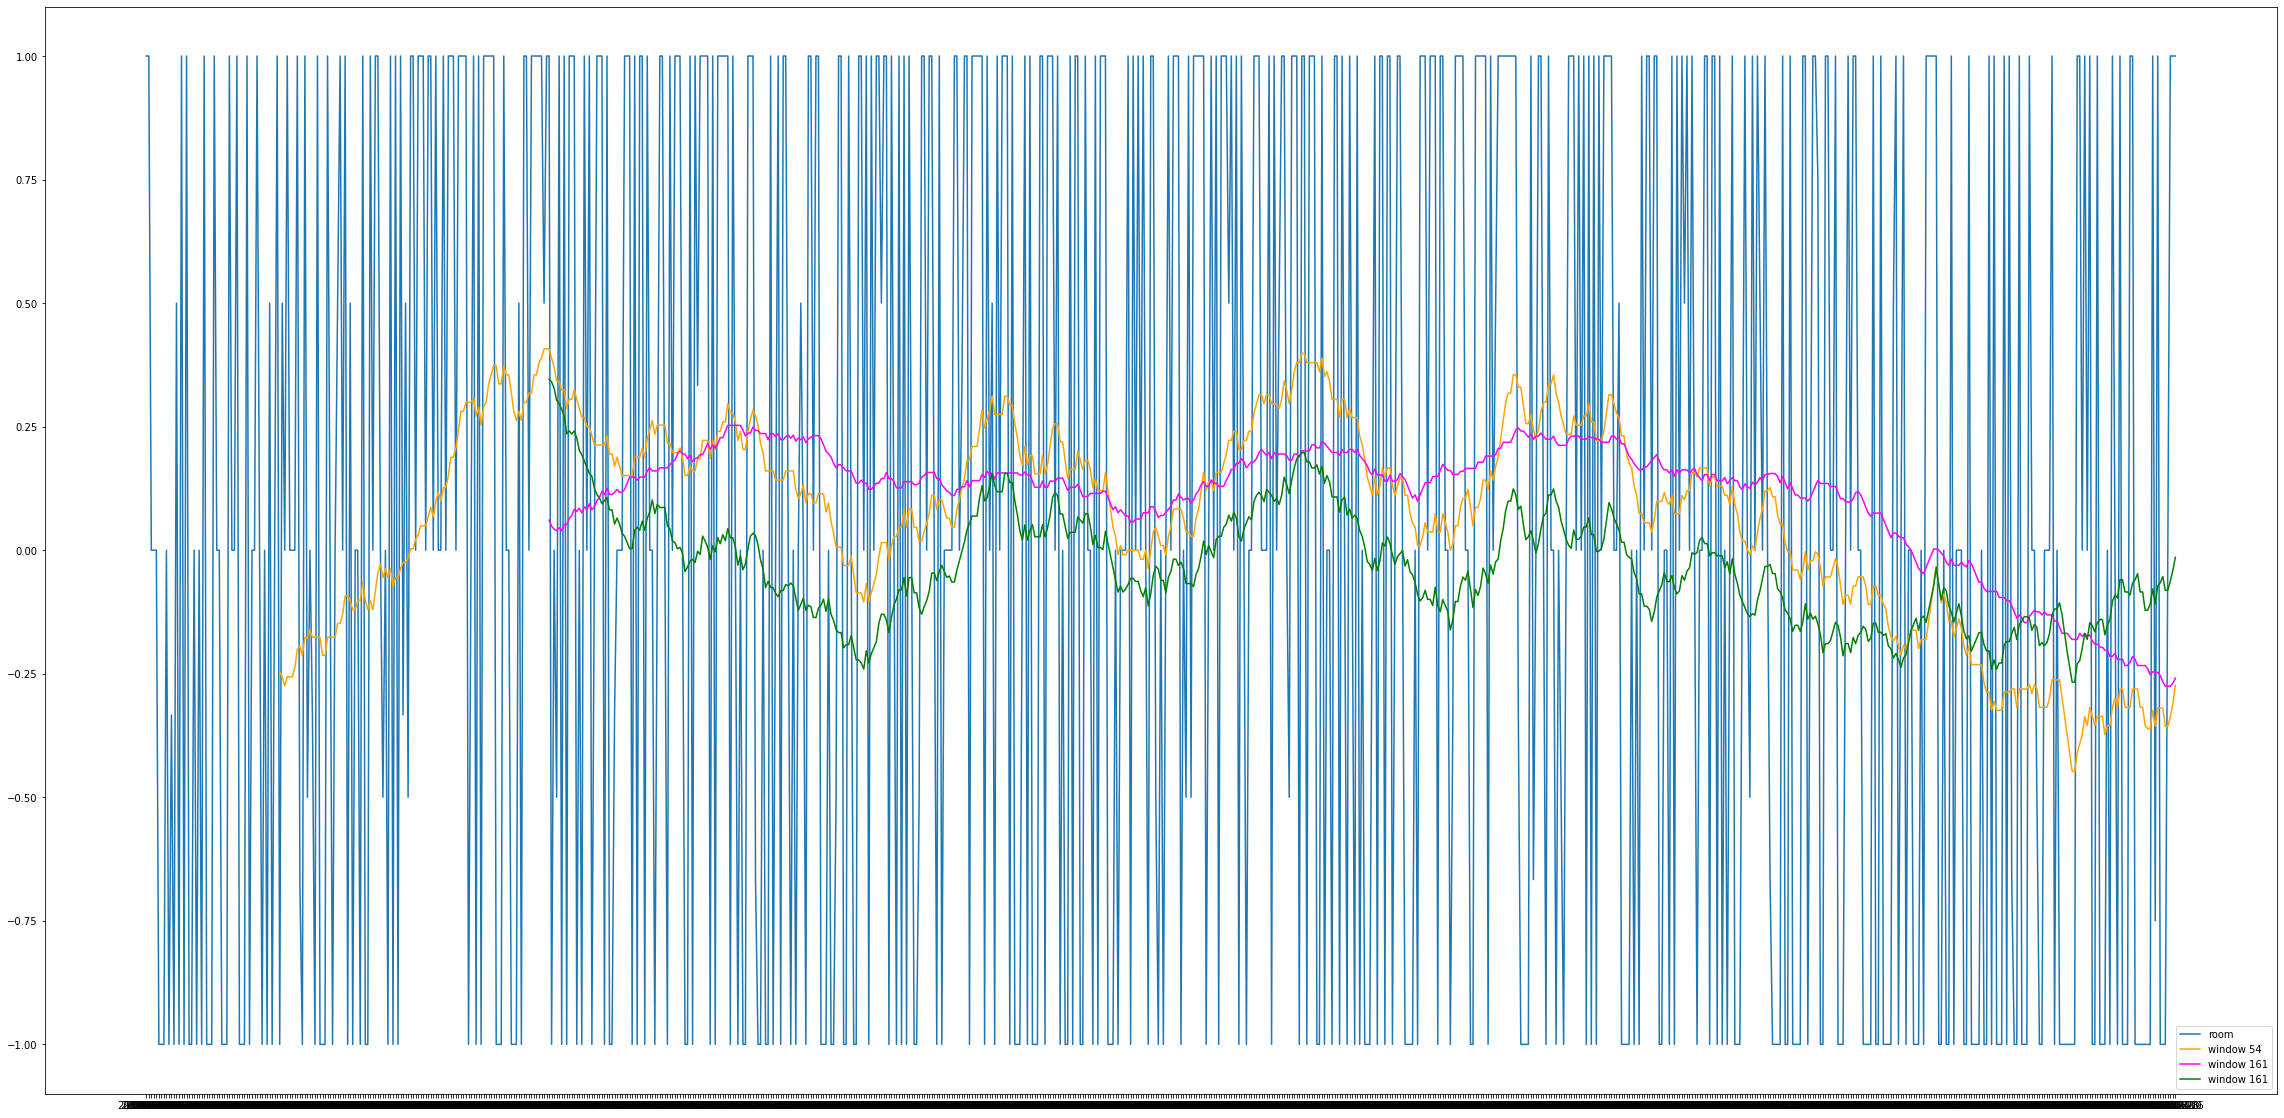

In [9]:
win1 = int(round(len(cpd_df)/15, 0))
win2 = int(round(len(cpd_df)/5, 0))
print(win1, win2)

rolling_mean = cpd_df.score.rolling(window=win1).mean()
rolling_mean2 = cpd_df.score.rolling(window=win2).mean()

diff = rolling_mean -rolling_mean2 

plt.figure(figsize=(40, 20))

plt.plot(cpd_df.date, cpd_df.score, label='room')
plt.plot(cpd_df.date, rolling_mean, label='window '+str(win1), color='orange')
plt.plot(cpd_df.date, rolling_mean2, label='window '+str(win2), color ='magenta')
plt.plot(cpd_df.date, diff, label='window '+str(win2), color ='green')

plt.legend(loc='lower right')

In [10]:
y = np.array(diff)
# dates to deploy
X = np.array(cpd_df.date)[~np.isnan(y)].tolist()
y = y[~np.isnan(y)]
scores =y

In [34]:
len(scores)

647

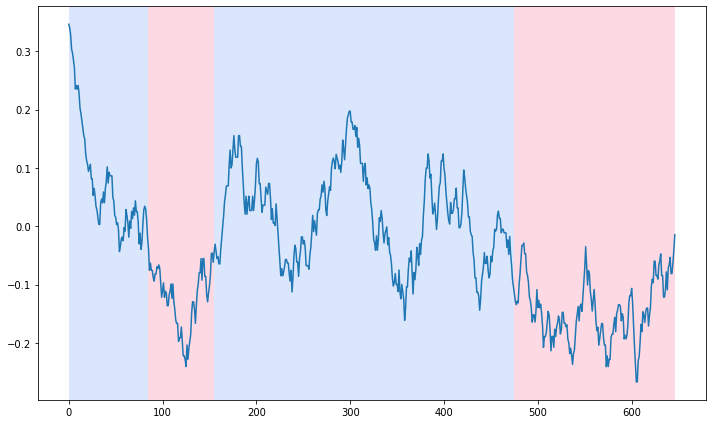

In [44]:
model = "normal"
algo = rpt.Dynp(model=model, min_size=3, jump=5).fit(scores)
my_bkps = algo.predict(n_bkps=3)
rpt.display(scores, my_bkps, figsize=(10, 6))
my_bkps
plt.savefig('test.png')

In [12]:
# get the period dictionary
periods = list(zip(my_bkps[:-1], my_bkps[1:]))
period_ids = {}
period_ids[0] = (0, my_bkps[0])
count=1
for z in periods:
    x,y = z
    period_ids[count]=(x,y)
    count+=1
print(period_ids)

{0: (0, 85), 1: (85, 155), 2: (155, 475), 3: (475, 647)}


In [13]:
period_scores ={}
period_scores[(0, my_bkps[0])] = np.mean(scores[:my_bkps[0]])

# reno_df
reno_df = df[df['renovation']==True]
df.loc[(df['date']<=X[period_ids[0][1]]), 'point'] = 0

for idx, period in period_ids.items():
    if idx >=1:
        start, end = period
        period_scores[(start, end)]= np.mean(scores[start:end])
        print(X[start], X[end-1])
        df.loc[(df['date']> X[start]) & (df['date']<=X[end-1]), 'point' ]=idx

        

2012-03-05 2013-02-27
2013-03-02 2017-07-22
2017-07-23 2020-03-16


In [14]:
reno_df = reno_df.sort_values('date')

In [15]:
period_scores

{(0, 85): 0.07696766307166987,
 (85, 155): -0.12219812240516177,
 (155, 475): 0.014581536116862245,
 (475, 647): -0.14434456936352785}

In [16]:
scores_list = list(period_scores.values())
score_pairs = list(zip(scores_list[:-1], scores_list[1:]))

In [17]:
score_pairs

[(0.07696766307166987, -0.12219812240516177),
 (-0.12219812240516177, 0.014581536116862245),
 (0.014581536116862245, -0.14434456936352785)]

In [18]:
period_ids

{0: (0, 85), 1: (85, 155), 2: (155, 475), 3: (475, 647)}

In [19]:
trends = []
start_score = score_pairs[0][0]

for x1,y1 in score_pairs:
    z = y1-x1
    if start_score <0:
        if z >0 :
            trends.append('low')
            trends.append('high')

    if start_score >0:
        if z< 0:
            trends.append('high')
            trends.append('low')

In [35]:
trends

['high', 'low', 'high', 'low']

In [36]:
period_ids

{0: (0, 85), 1: (85, 155), 2: (155, 475), 3: (475, 647)}

In [20]:
other_topics_keywords=['pool', 'suite', 'minibar','view', 'restaurant', 'menu', 'lobby', 'parking', 'park']

In [21]:
df['other'] = df.apply(lambda x :sum([ y in x.lemma for y in other_topics_keywords])>0, axis=1)

In [26]:
reno_df = df[(df['renovation']==True) & (df['other']==True)]

In [25]:
other_df = df[(df['renovation']==False) & (df['other']==True)]

In [45]:
uids = {}
sentences = {}

for idx, period in period_ids.items():
    trend=trends[idx]
    print(trend)
    if trend =='low':
        df_idx = reno_df[reno_df['point']==idx][reno_df['polarity'] == -1]
        df_other_idx = other_df[other_df['point']==idx][other_df['polarity']==-1]
        if len(df_idx)>10:
            df_idx =df_idx.sample(10)    
        if len(df_other_idx):
            df_other_idx = df_other_idx.sample(10)

    if trend=='high':
        df_idx = reno_df[reno_df['point']==idx][reno_df['polarity'] == 1]
        df_other_idx = other_df[other_df['point']==idx][other_df['polarity']==1]
        if len(df_idx)>10:
            df_idx =df_idx.sample(10)    
        if len(df_other_idx):
            df_other_idx = df_other_idx.sample(10)

    sent = df_idx.sentence.to_list()+df_other_idx.sentence.to_list()
    dates = df_idx.date.to_list()+df_other_idx.date.to_list()
    uidss = df_idx.uid.to_list()+df_other_idx.uid.to_list()
    
    sent_date =sorted(list(zip(sent, dates)), key= lambda x: x[1])
    uid_date = sorted(list(zip(uidss, dates)), key = lambda x: x[1])
    sentences[(idx,trend)] = sent_date
    uids[(idx, trend)] =  uid_date


high
low
high
low


/home/yiyi/anaconda3/envs/cpd/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/home/yiyi/anaconda3/envs/cpd/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/yiyi/anaconda3/envs/cpd/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/yiyi/anaconda3/envs/cpd/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [ ]:
sentences

In [30]:
import csv

filepath = os.path.join(result_dir, filename+'.csv')
with open(filepath, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='\"', quoting=csv.QUOTE_MINIMAL)
    csvwriter.writerow(['date', 'sentence', 'typical?(renovation) yes or no'])
    for idx_trend, reviews in sentences.items():
        idx, trend = idx_trend
        for review in reviews:
            sentence, date = review
            csvwriter.writerow([date, sentence, ''])
        if trend=='low':
            csvwriter.writerow(['change point: ','going up',  ''])
        if trend=='high':
            csvwriter.writerow(['change point: ', 'going down',  ''])
   